## Antispoofing Module Training and Evaluation

The provided Python code performs an anti-spoofing task using a deep learning model (MobileNetV2) to classify face images as "real" or "spoof" by training on the combined dataset (MSU-MFSD Photos + NUAA Photograph Imposter Database). Additionally, it explores the use of Local Binary Patterns (LBP) as a preprocessing step.

The code loads pre-saved NumPy arrays containing images (X_combined), labels (y_combined), and real/spoof status (S_combined). These arrays are split into training, validation and test datasets. The images are passed through the MobileNetV2 model to perform binary classification, where the model is trained and evaluated with accuracy, precision, recall, F1-score, APCER (Attack Presentation Classification Error Rate), BPCER (Bona Fide Presentation Classification Error Rate) and ACER (Average Classification Error Rate).

The first half of the code does the following:

1. **Data Loading & Visualization**: 
the dataset is loaded from .npy files. A random subset of 20 images is selected and displayed, with the "spoof" or "real" status as titles on each image.

2. **Local Binary Pattern (LBP)**:
some functions are defined to apply LBP to individual channels of an image. This operation extracts texture features which can help in distinguishing between spoofed and real images. After computing the LBP for each color channel, the transformed image is normalized and returned.

3. **Custom Dataset Class**:
a PyTorch Dataset class (ImageDataset) is implemented to handle image transformations and optionally apply LBP preprocessing to each image during data loading.

4. **Training & Validation Split**:
the combined dataset is split into training, validation and test sets. A portion of the data is reserved for validation and the remaining for testing.

5. **Model Initialization and Training**:
a MobileNetV2 model is modified for binary classification by adjusting the final layer. The model is trained using binary cross-entropy loss with logits, and Adam optimizer over 10 epochs. The model's performance is tracked by calculating the training and validation losses and accuracies at each epoch.

6. **Performance Evaluation**:
after training, the model is evaluated on the test set. Key performance metrics like accuracy, precision, recall and F1-score are calculated, along with specific metrics used in spoof detection: APCER (Attack Presentation Classification Error Rate), BPCER (Bona Fide Presentation Classification Error Rate) and ACER (Average Classification Error Rate).

7. **Visualization**:
training and validation curves (for loss and accuracy) are plotted to visualize the model's performance over time. A confusion matrix is also displayed to summarize the classification results on the test set.

The second half of the code does the following:

8. **LBP Preprocessing Evaluation**:
the second half of the code evaluates the impact of using LBP as preprocessing. The same MobileNetV2 model is retrained on the LBP-transformed images, and its performance is compared against the model trained on the original images.

## Dataset upload and image preprocessing

In [4]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import warnings
from torchsummary import summary

In [5]:
warnings.filterwarnings("ignore")  # Suppress all warnings
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
# Load preprocessed image data, labels, and real/spoof status
X_combined = np.load(r"C:\Users\Asus\Desktop\Biometric Systems\Numpy_arrays\X_combined.npy")
y_combined = np.load(r"C:\Users\Asus\Desktop\Biometric Systems\Numpy_arrays\y_combined.npy")
S_combined = np.load(r"C:\Users\Asus\Desktop\Biometric Systems\Numpy_arrays\S_combined.npy")

print("Shape of X_combined:", X_combined.shape)
print("Shape of y_combined:", y_combined.shape)
print("Shape of S_combined:", S_combined.shape)

Shape of X_combined: (50547, 224, 224, 3)
Shape of y_combined: (50547,)
Shape of S_combined: (50547,)


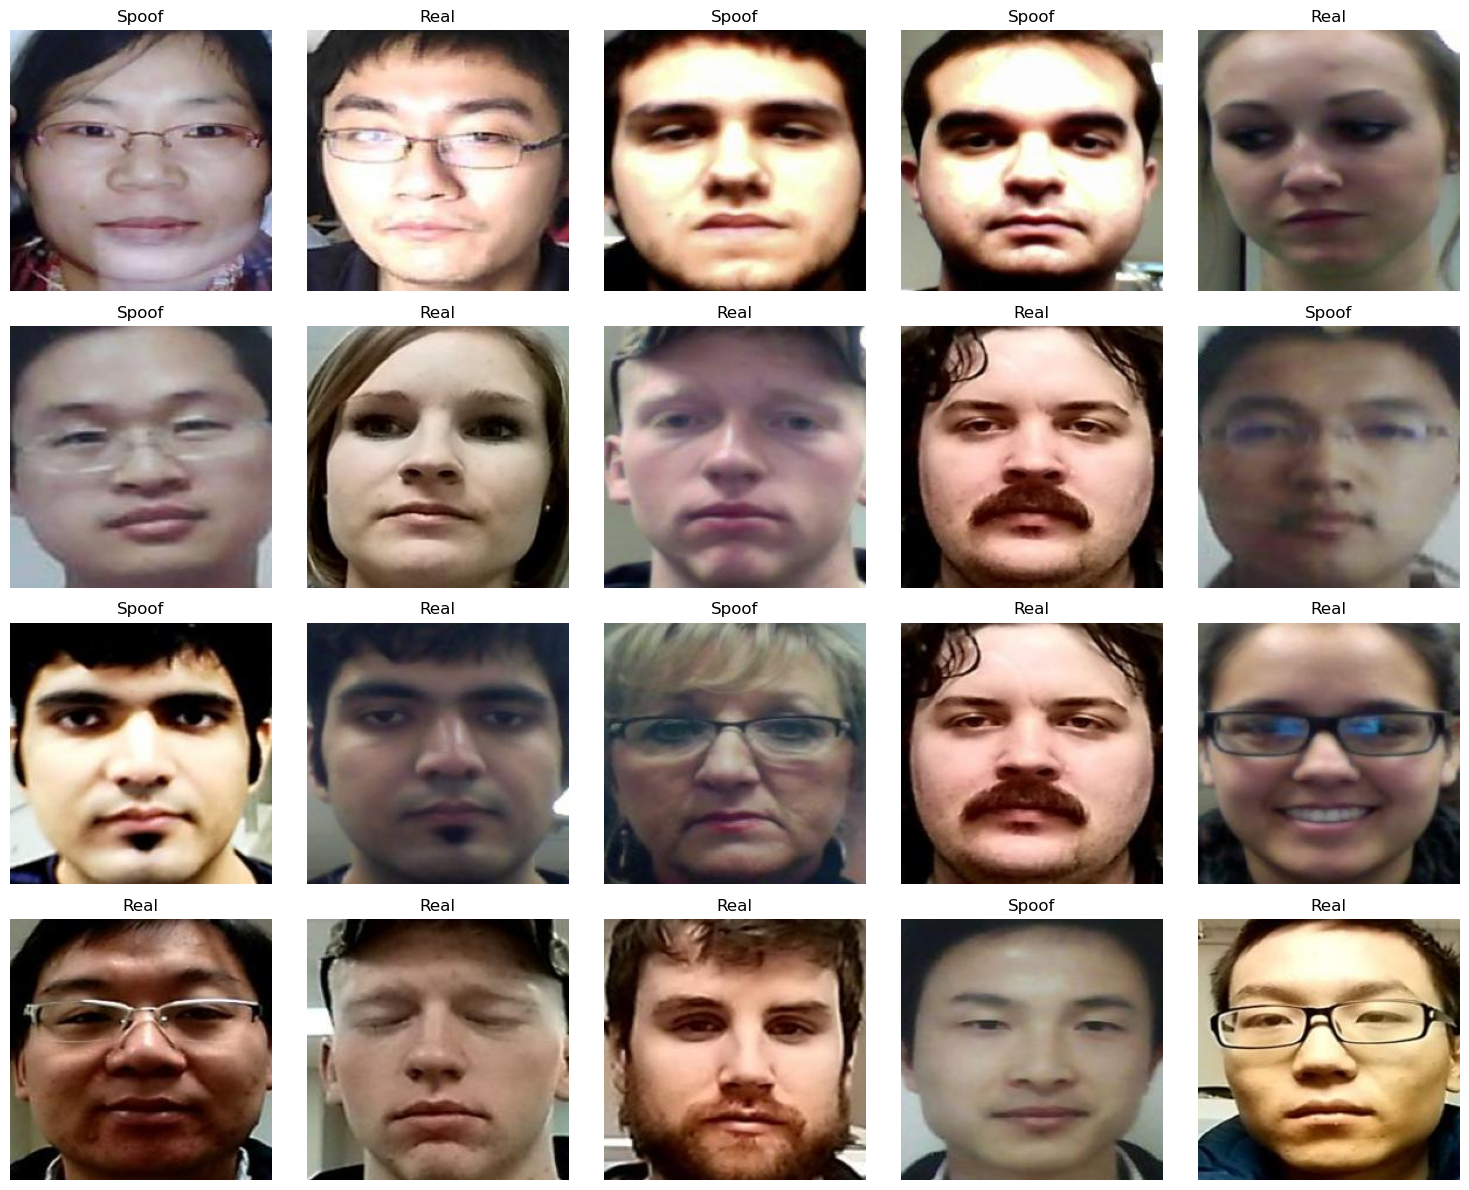

In [7]:
num_images = 20
random_indices = np.random.choice(X_combined.shape[0], num_images, replace=False)

fig, axes = plt.subplots(4, 5, figsize=(15, 12))

# Loop through each axis and display a randomly selected image
for i, ax in enumerate(axes.flat):
    idx = random_indices[i]

    # Convert image from BGR to RGB
    image_rgb = X_combined[idx][..., ::-1]
    
    # Display the image on the axis
    ax.imshow(image_rgb)
    
    # Display the spoof status (Spoof or Real) as the title
    spoof_status = "Spoof" if S_combined[idx] == 1 else "Real"
    ax.set_title(f"{spoof_status}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [8]:
# LBP (Local Binary Pattern) parameters for texture analysis
radius = 1  # Radius for LBP
n_points = 8 * radius  # Number of points sampled in LBP

# Function to apply LBP to each channel
def apply_lbp(channel):
    return local_binary_pattern(channel, n_points, radius, method='uniform')

# Function to apply LBP to an image
def lbp_transform(image):
    lbp_r = apply_lbp(image[:, :, 0])
    lbp_g = apply_lbp(image[:, :, 1])
    lbp_b = apply_lbp(image[:, :, 2])
    
    # Normalize the LBP results to fit in the range [0, 255]
    lbp_r_normalized = cv2.normalize(lbp_r, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX).astype(np.uint8)
    lbp_g_normalized = cv2.normalize(lbp_g, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX).astype(np.uint8)
    lbp_b_normalized = cv2.normalize(lbp_b, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX).astype(np.uint8)
    lbp_color = cv2.merge((lbp_r_normalized, lbp_g_normalized, lbp_b_normalized))
    return lbp_color

In [9]:
class ImageDataset(Dataset):
    def __init__(self, images, labels, transform=None, additional_preprocessing=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.additional_preprocessing = additional_preprocessing

    # Return the length of the dataset
    def __len__(self):
        return len(self.images)

    # Get an item (image and label) at a specific index
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.additional_preprocessing == 'lbp': # Apply LBP preprocessing if specified
            image = lbp_transform(image)

        if self.transform: # Apply other transformations (resizing, normalization)
            image = self.transform(image)
        return image, label

In [10]:
# Training parameters
IMG_SIZE = (224, 224)
EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 0.0001

# Image transformations: resize, convert to tensor, normalize
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# First split: training set and temporary set (which will be further split into validation and test sets)
X_train, X_temp, S_train, S_temp = train_test_split(X_combined, S_combined, test_size=0.2, random_state=42)

# Second split: validation set and test set
X_val, X_test, S_val, S_test = train_test_split(X_temp, S_temp, test_size=0.5, random_state=42)

In [11]:
print("X_train shape:", X_train.shape)
print("S_train shape:", S_train.shape)
print("X_val shape:", X_val.shape)
print("S_val shape:", S_val.shape)
print("X_test shape:", X_test.shape)
print("S_test shape:", S_test.shape)

X_train shape: (40437, 224, 224, 3)
S_train shape: (40437,)
X_val shape: (5055, 224, 224, 3)
S_val shape: (5055,)
X_test shape: (5055, 224, 224, 3)
S_test shape: (5055,)


## Utlis

In [13]:
def save_model(model, model_name_pth):
    torch.save(model.state_dict(), model_name_pth)

## MobileNet Model Training and Evaluation

In [15]:
# Create PyTorch datasets for training and validation sets without LBP preprocessing
train_dataset = ImageDataset(X_train, S_train, transform=transform, additional_preprocessing=None)
val_dataset = ImageDataset(X_val, S_val, transform=transform, additional_preprocessing=None)

In [16]:
# Data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [17]:
# Function to load a MobileNetV2 model and modify it for binary classification
def load_mobilenet(learning_rate, device):
    model = models.mobilenet_v2(pretrained=True) # Load pretrained MobileNetV2

    # Modify the last layer for binary classification (Real or Spoof)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)
    model = model.to(device)
    
    # Define Binary-Cross-Entropy loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return model, criterion, optimizer

In [18]:
# Training function for the MobileNetV2 model
def train_and_eval_mobilenet(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Loop over the number of epochs
    for epoch in range(epochs):
        model.train() # Return the length of the dataset
        running_loss = 0.0
        correct = 0
        total = 0
    
        for images, labels in train_loader:
            images = images.to(device) # Move images to the device 
            labels = labels.float().unsqueeze(1).to(device) # Move labels to the device
    
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float() # Apply threshold to predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item() # Count correct predictions
    
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval() # Set model to evaluation mode
        val_loss = 0.0
        correct = 0
        total = 0
    
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.float().unsqueeze(1).to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
    
                val_loss += loss.item()
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
    
        val_loss /= len(val_loader)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
    
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    
    return model, train_losses, val_losses, train_accuracies, val_accuracies


In [19]:
def load_trained_mobilenet_model(model_path, device):
    loaded_model = models.mobilenet_v2(pretrained=False)
    loaded_model.classifier[1] = nn.Linear(loaded_model.classifier[1].in_features, 1)      
    loaded_model.load_state_dict(torch.load(model_path)) 
    loaded_model = loaded_model.to(device)
    loaded_model.eval()
    return loaded_model

In [20]:
def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = len(train_losses)
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs+1), val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, epochs+1), val_accuracies, label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.show()

In [21]:
# Function to test the model on the test dataset and compute various metrics
def test_model(loaded_model, test_loader):
    threshold = 0.5
    results = []
    
    with torch.no_grad():
        corrects = 0
        total = 0
        TP = FP = TN = FN = 0

        # Iterate through the test images
        for images, labels in test_loader:
            images, labels = images.to(device), labels.float().to(device).unsqueeze(1)
    
            outputs = loaded_model(images)
            preds = torch.sigmoid(outputs) > threshold # Apply threshold to the predictions


            TP += ((preds == 0) & (labels == 0)).sum().item() # True Positives: cases where the model predicted 0 (positive/real) and the actual label is also 0 (real)                    
            TN += ((preds == 1) & (labels == 1)).sum().item() # True Negatives: cases where the model predicted 1 (negative/spoof) and the actual label is also 1 (spoof)
            FP += ((preds == 0) & (labels == 1)).sum().item() # False Positives: cases where the model predicted 0 (positive/real), but the actual label is 1 (spoof)
            FN += ((preds == 1) & (labels == 0)).sum().item() # False Negatives: cases where the model predicted 1 (negatives/spoof), but the actual label is 0 (real)
    
            corrects += (preds == labels).sum().item()
            total += labels.size(0)
    
        APCER = FP / (FP + TN) if (FP + TN) > 0 else 0 # APCER (Attack Presentation Classification Error Rate)
        BPCER = FN / (FN + TP) if (FN + TP) > 0 else 0 # BPCER (Bona Fide Presentation Classification Error Rate)
        ACER = (APCER + BPCER) / 2 # ACER (Average Classification Error Rate)
        accuracy = corrects / total
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
        results.append({
            'accuracy': accuracy,
            'APCER': APCER,
            'BPCER': BPCER,
            'ACER': ACER,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score,
            'TP': TP,
            'TN': TN,
            'FP': FP,
            'FN': FN
        })
    
        print(f'APCER: {APCER:.2f}, BPCER: {BPCER:.2f}, ACER: {ACER:.2f}')
        print(f'Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1_score:.2f}')
        
    return loaded_model, results, TP, TN, FP, FN

In [22]:
# Confusion matrix to visualize the classification performance
def plot_confusion_matrix(TP, TN, FP, FN):
    cm = np.array([[TN, FP], [FN, TP]])
    labels = ['Real', 'Spoof']
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [23]:
model, criterion, optimizer = load_mobilenet(LEARNING_RATE, device)

In [24]:
summary(model, input_size=(3, 224, 224), verbose=0)

Layer (type:depth-idx)                             Param #
├─Sequential: 1-1                                  --
|    └─Conv2dNormActivation: 2-1                   --
|    |    └─Conv2d: 3-1                            864
|    |    └─BatchNorm2d: 3-2                       64
|    |    └─ReLU6: 3-3                             --
|    └─InvertedResidual: 2-2                       --
|    |    └─Sequential: 3-4                        896
|    └─InvertedResidual: 2-3                       --
|    |    └─Sequential: 3-5                        5,136
|    └─InvertedResidual: 2-4                       --
|    |    └─Sequential: 3-6                        8,832
|    └─InvertedResidual: 2-5                       --
|    |    └─Sequential: 3-7                        10,000
|    └─InvertedResidual: 2-6                       --
|    |    └─Sequential: 3-8                        14,848
|    └─InvertedResidual: 2-7                       --
|    |    └─Sequential: 3-9                        14,848
|  

In [25]:
# Train MobileNetV2 on the original dataset (no LBP)
model, train_losses, val_losses, train_accuracies, val_accuracies = train_and_eval_mobilenet(model, train_loader, val_loader, criterion, optimizer, EPOCHS, device)

Epoch 1/10, Train Loss: 0.0144, Train Accuracy: 99.56%, Val Loss: 0.0001, Val Accuracy: 100.00%
Epoch 2/10, Train Loss: 0.0013, Train Accuracy: 99.97%, Val Loss: 0.0002, Val Accuracy: 99.98%
Epoch 3/10, Train Loss: 0.0048, Train Accuracy: 99.86%, Val Loss: 0.0002, Val Accuracy: 100.00%
Epoch 4/10, Train Loss: 0.0018, Train Accuracy: 99.94%, Val Loss: 0.0014, Val Accuracy: 99.98%
Epoch 5/10, Train Loss: 0.0006, Train Accuracy: 99.98%, Val Loss: 0.0002, Val Accuracy: 99.98%
Epoch 6/10, Train Loss: 0.0002, Train Accuracy: 100.00%, Val Loss: 0.0001, Val Accuracy: 100.00%
Epoch 7/10, Train Loss: 0.0012, Train Accuracy: 99.96%, Val Loss: 0.0003, Val Accuracy: 100.00%
Epoch 8/10, Train Loss: 0.0014, Train Accuracy: 99.96%, Val Loss: 0.0026, Val Accuracy: 99.92%
Epoch 9/10, Train Loss: 0.0004, Train Accuracy: 99.99%, Val Loss: 0.0000, Val Accuracy: 100.00%
Epoch 10/10, Train Loss: 0.0008, Train Accuracy: 99.97%, Val Loss: 0.0005, Val Accuracy: 99.94%


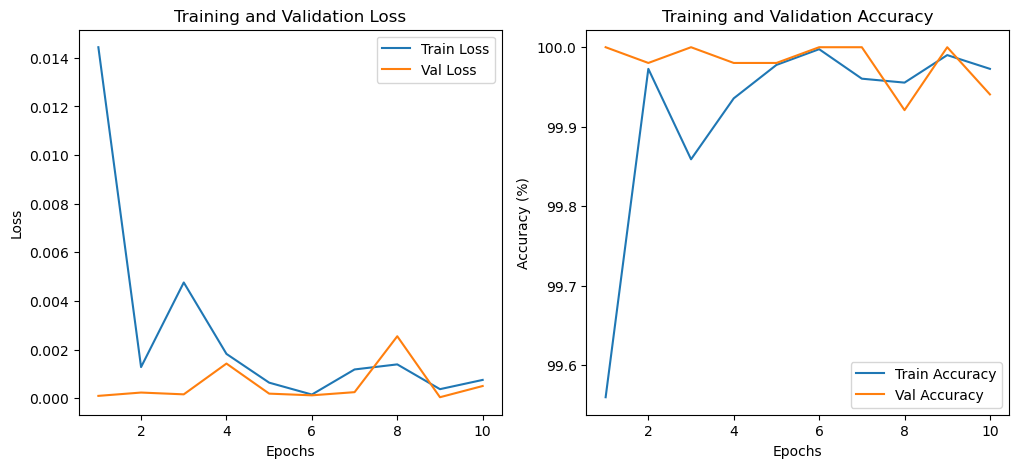

In [26]:
# Plot training and validation losses over epochs
plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)

In [27]:
# Load the test set into a PyTorch dataset
test_dataset = ImageDataset(X_test, S_test, transform=transform, additional_preprocessing=None)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [28]:
# Test the trained model on the test set
loaded_model, results, TP, TN, FP, FN = test_model(model, test_loader)

APCER: 0.00, BPCER: 0.00, ACER: 0.00
Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-Score: 1.00


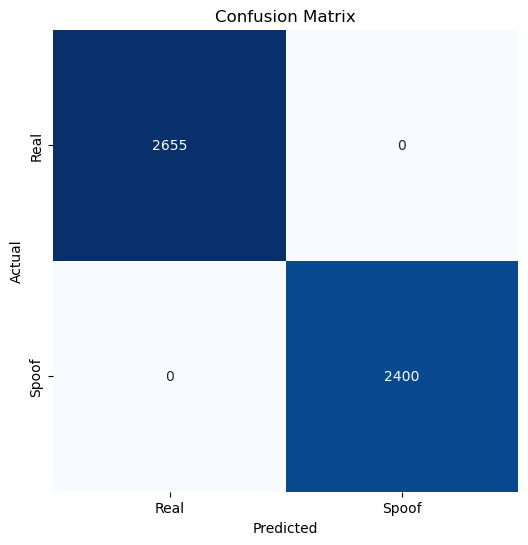

In [29]:
plot_confusion_matrix(TP=results[0]['TP'], TN=results[0]['TN'], FP=results[0]['FP'], FN=results[0]['FN'])

In [30]:
save_model(model, "mobilenet_v2_combined_model.pth")

## LBP Preprocessing + MobileNet Model Training and Evaluation

In [32]:
# Evaluate the effect of LBP preprocessing on model performance

# Create a dataset where LBP is applied during loading
train_dataset_lbp = ImageDataset(X_train, S_train, transform=transform, additional_preprocessing='lbp')
val_dataset_lbp = ImageDataset(X_val, S_val, transform=transform, additional_preprocessing='lbp')

In [33]:
# Create loaders for the LBP-processed datasets
train_loader_lbp = DataLoader(train_dataset_lbp, batch_size=BATCH_SIZE, shuffle=True)
val_loader_lbp = DataLoader(val_dataset_lbp, batch_size=BATCH_SIZE, shuffle=False)

In [34]:
# Load a new MobileNetV2 model for training on LBP-transformed images
model_lbp, criterion, optimizer = load_mobilenet(LEARNING_RATE, device)

In [35]:
# Train MobileNetV2 on the LBP-transformed dataset
model_lbp, train_losses_lbp, val_losses_lbp, train_accuracies_lbp, val_accuracies_lbp = train_and_eval_mobilenet(model_lbp, train_loader_lbp, val_loader_lbp, criterion, optimizer, EPOCHS, device)

Epoch 1/10, Train Loss: 0.0302, Train Accuracy: 98.83%, Val Loss: 0.0015, Val Accuracy: 99.94%
Epoch 2/10, Train Loss: 0.0028, Train Accuracy: 99.92%, Val Loss: 0.0027, Val Accuracy: 99.90%
Epoch 3/10, Train Loss: 0.0038, Train Accuracy: 99.88%, Val Loss: 0.0079, Val Accuracy: 99.66%
Epoch 4/10, Train Loss: 0.0023, Train Accuracy: 99.93%, Val Loss: 0.0006, Val Accuracy: 99.96%
Epoch 5/10, Train Loss: 0.0030, Train Accuracy: 99.91%, Val Loss: 0.0007, Val Accuracy: 100.00%
Epoch 6/10, Train Loss: 0.0016, Train Accuracy: 99.94%, Val Loss: 0.0005, Val Accuracy: 99.98%
Epoch 7/10, Train Loss: 0.0012, Train Accuracy: 99.96%, Val Loss: 0.0007, Val Accuracy: 99.96%
Epoch 8/10, Train Loss: 0.0020, Train Accuracy: 99.95%, Val Loss: 0.0036, Val Accuracy: 99.90%
Epoch 9/10, Train Loss: 0.0009, Train Accuracy: 99.97%, Val Loss: 0.0002, Val Accuracy: 100.00%
Epoch 10/10, Train Loss: 0.0008, Train Accuracy: 99.98%, Val Loss: 0.0003, Val Accuracy: 99.98%


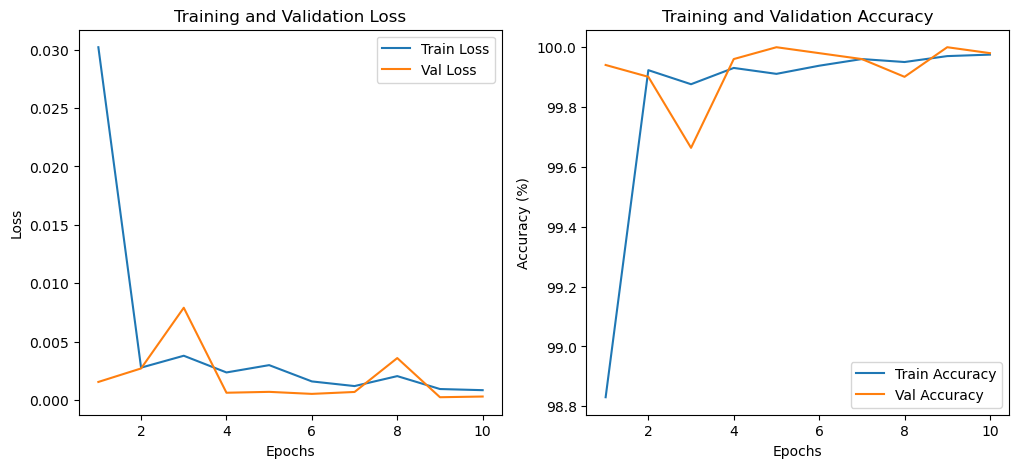

In [36]:
# Plot training and validation losses for LBP model
plot_training_curves(train_losses_lbp, val_losses_lbp, train_accuracies_lbp, val_accuracies_lbp)

In [37]:
test_dataset_lbp = ImageDataset(X_test, S_test, transform=transform, additional_preprocessing='lbp')
test_loader_lbp = DataLoader(test_dataset_lbp, batch_size=BATCH_SIZE, shuffle=False)

In [38]:
# Test the model trained on LBP-transformed images
loaded_model_lbp, results_lbp, TP_lbp, TN_lbp, FP_lbp, FN_lbp = test_model(model_lbp, test_loader_lbp)

APCER: 0.00, BPCER: 0.00, ACER: 0.00
Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-Score: 1.00


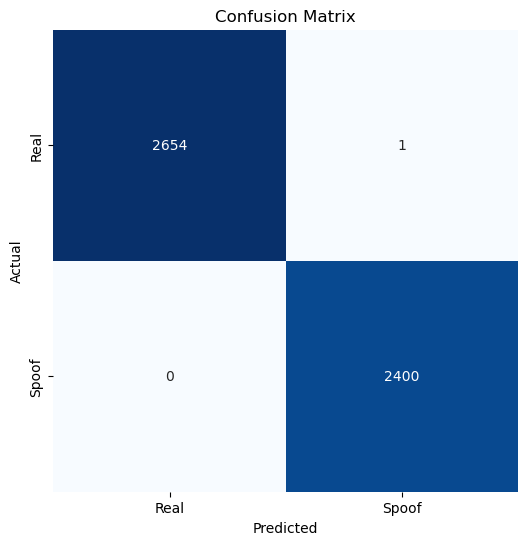

In [39]:
plot_confusion_matrix(TP=results_lbp[0]['TP'], TN=results_lbp[0]['TN'], FP=results_lbp[0]['FP'], FN=results_lbp[0]['FN'])

In [40]:
save_model(model_lbp, "mobilenet_v2_lbp_combined_model.pth")